# Análise de Mídias Sociais: Twitter

Para autenticar no twitter, temos que criar uma conta e accessar: <br />
http://twitter.com/apps/ <br />
Gerar as chaves de autenticação, ex:<br />
CONSUMER_KEY = 'Riew8e4LKVoEJ51HbeOm6wsYA' <br />
CONSUMER_SECRET = '3pPE1z3kTJGQiY93yCqgLUTURJO2wOcoQCcMbyMbCj4Gm9Hc6N' <br />
OAUTH_TOKEN = '2904474861-kdalTd2NVus3q0PdvAiD3gB2IlF9IFZzao01ol7' <br />
OAUTH_TOKEN_SECRET = '2yHMlMAEUZflpw5swYaLA8EjFyPyPJWnJT84VJoAHDKCU' <br />

## Modulo para autenticação no twitter

In [1]:
import twitter

def oauth_login():
    # XXX: Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation.
    
    CONSUMER_KEY = 'Riew8e4LKVoEJ51HbeOm6wsYA'
    CONSUMER_SECRET = '3pPE1z3kTJGQiY93yCqgLUTURJO2wOcoQCcMbyMbCj4Gm9Hc6N'
    OAUTH_TOKEN = '2904474861-kdalTd2NVus3q0PdvAiD3gB2IlF9IFZzao01ol7'
    OAUTH_TOKEN_SECRET = '2yHMlMAEUZflpw5swYaLA8EjFyPyPJWnJT84VJoAHDKCU'
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

# Sample usage
twitter_api = oauth_login()    

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print (twitter_api)

## Módulo para buscar tweets, dado uma palavra

In [2]:
def twitter_search(twitter_api, q, max_results=1000, **kw):  #max_results=200

    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets and 
    # https://dev.twitter.com/docs/using-search for details on advanced 
    # search criteria that may be useful for keyword arguments
    
    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets    
    search_results = twitter_api.search.tweets(q=q, count=1000, **kw)   # count=100
    
    statuses = search_results['statuses']
    
    # Iterate through batches of results by following the cursor until we
    # reach the desired number of results, keeping in mind that OAuth users
    # can "only" make 180 search queries per 15-minute interval. See
    # https://dev.twitter.com/docs/rate-limiting/1.1/limits
    # for details. A reasonable number of results is ~1000, although
    # that number of results may not exist for all queries.
    
    # Enforce a reasonable limit
    max_results = min(1000, max_results)
    
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses

## Salvando/Recuperando no MongoDB

In [3]:
import json
import pymongo # pip install pymongo


def save_to_mongo(data, mongo_db, mongo_db_coll, **mongo_conn_kw):
    
    # Connects to the MongoDB server running on 
    # localhost:27017 by default
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    
    # Get a reference to a particular database
    
    db = client[mongo_db]
    
    # Reference a particular collection in the database
    
    coll = db[mongo_db_coll]
    
    # Perform a bulk insert and  return the IDs
    
    return coll.insert_many(data)

def load_from_mongo(mongo_db, mongo_db_coll, return_cursor=False,
                    criteria=None, projection=None, **mongo_conn_kw):
    
    # Optionally, use criteria and projection to limit the data that is 
    # returned as documented in 
    # http://docs.mongodb.org/manual/reference/method/db.collection.find/
    
    # Consider leveraging MongoDB's aggregations framework for more 
    # sophisticated queries.
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    db = client[mongo_db]
    coll = db[mongo_db_coll]
    
    if criteria is None:
        criteria = {}
    
    if projection is None:
        cursor = coll.find(criteria)
    else:
        cursor = coll.find(criteria, projection)

    # Returning a cursor is recommended for large amounts of data
    
    if return_cursor:
        return cursor
    else:
        return [ item for item in cursor ]

## Capturando tweets

In [4]:
q = 'tesla'

twitter_api = oauth_login()
results = []
for i in range(8):
    result = twitter_search(twitter_api, q, max_results=1000)
    print ('capturando ', len(result),' tweets...')
    #results.append(result)
    results += result
#print(type(result))
#print(type(results))
print("Numero de tweets capturados: ", len(results))

#results = twitter_search(twitter_api, q, max_results=1000)
#save_to_mongo(results, 'tweets', q)

capturando  195  tweets...
capturando  197  tweets...
capturando  197  tweets...
capturando  199  tweets...
capturando  199  tweets...
capturando  271  tweets...
capturando  271  tweets...
capturando  273  tweets...
Numero de tweets capturados:  1802


## imprimindo tweets

In [5]:
i = 0
for tweet in results:
    print(tweet['created_at'], ' >> ', tweet['text']) #, " >> ") #, tweet['place'])
    i += 1
    if i > 10:
          break

Thu Apr 05 12:24:57 +0000 2018  >>  $TSLA Short term Elliott wave view, we can be in a wave 4.#elliottwave https://t.co/k8R6xjWspK read this blog.#elliottwave $NQ_F $SPX
Thu Apr 05 12:24:51 +0000 2018  >>  Commented on $AAPL $TSLA https://t.co/Dm2cHgkVYE
Thu Apr 05 12:24:49 +0000 2018  >>  Otro ejemplo de cómo fue posible llevar energía a una ciudad en Filipinas por medio de #PanelesSolares☀️ (Las Vegas… https://t.co/2Nkulh89HO
Thu Apr 05 12:24:49 +0000 2018  >>  RT @ErikVoorhees: Suggestion to Tesla to help with capital problems: Do an ICO (could raise $1-4 billion), wherein the token grants free or…
Thu Apr 05 12:24:40 +0000 2018  >>  La production de la la #TeslaModel3  commence à décoller https://t.co/H3QO3Rez41
Thu Apr 05 12:24:29 +0000 2018  >>  Waarom Tesla geen partij is voor de klassieke autobouwers ... gelezen via https://t.co/1S7ZOOlWwn
Thu Apr 05 12:24:27 +0000 2018  >>  Tesla Inc (NASDAQ: TSLA) Still Struggles While Its Ford Motor Company (NYSE:F) Seems To Be Making It All

## Nuvem de Palavras - tweet

### Stopwords

In [13]:
# instalando o módulo de stopwords
#!pip install stop-words

In [14]:
from stop_words import get_stop_words
stop_words_english = get_stop_words('en')
#stop_words
stop_words_portugues = get_stop_words('pt')
#stop_words_portugues
stop_words = stop_words_english + stop_words_portugues
print(stop_words[:10])
print(stop_words[-10:])

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']
['tém', 'tínhamos', 'um', 'uma', 'você', 'vocês', 'vos', 'à', 'às', 'éramos']


156714


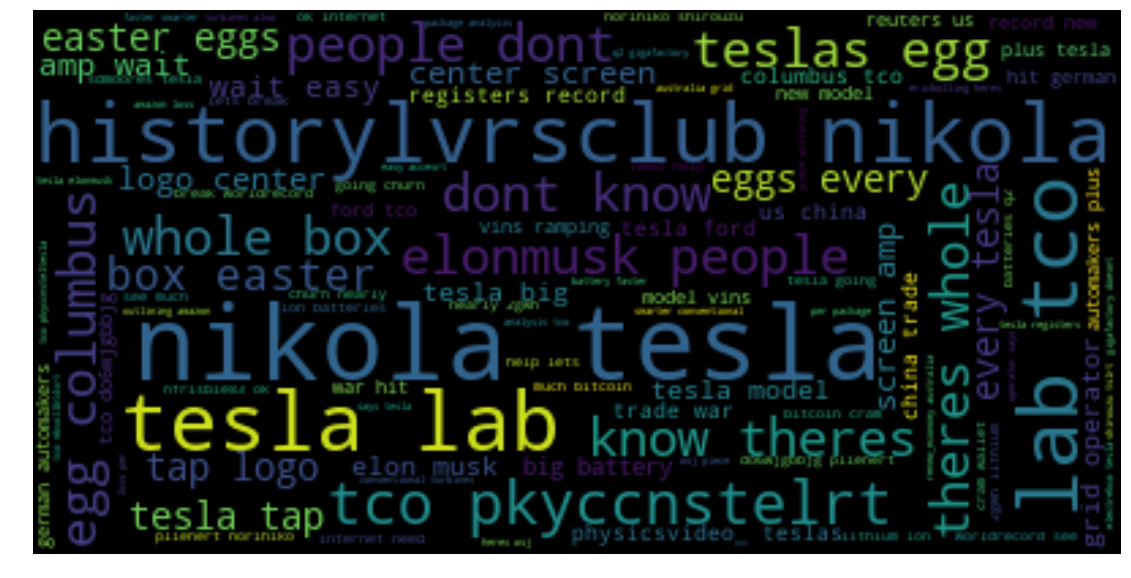

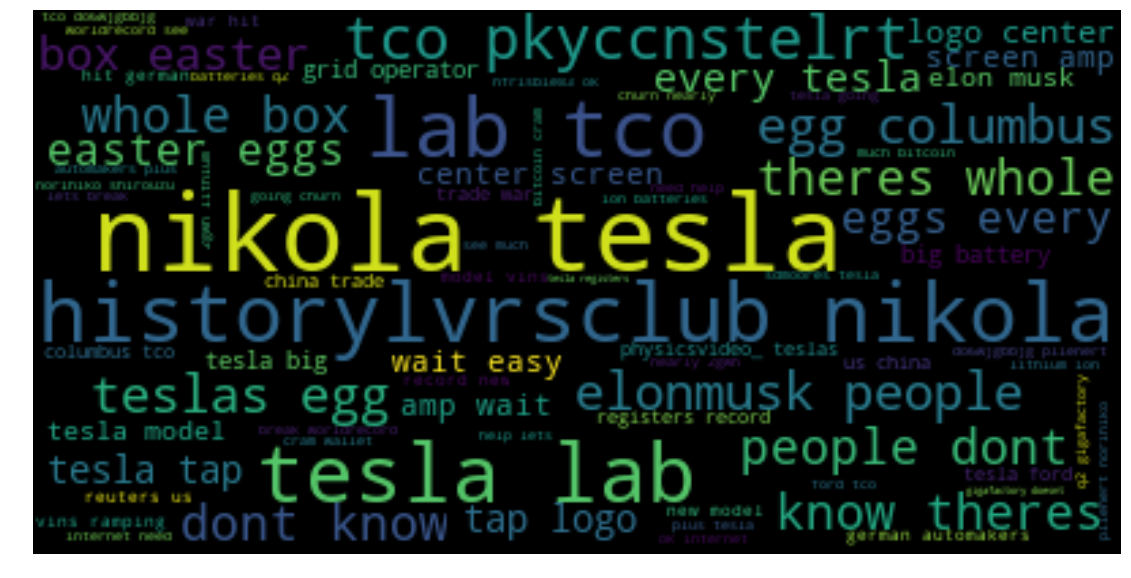

In [16]:
# nuvem de palavras
from wordcloud import WordCloud, STOPWORDS
import re

stext = ""
for tweet in results:
    if 'text' in tweet:
        stext = stext + tweet['text']
stext = stext.lower()

# retirando pontuações e outros caracteres não relevantes
stext = "".join([i for i in stext if ord(i)<128])
stext = stext.replace("http://","")
stext = stext.replace("https://","")
stext = stext.replace("https","")
stext = stext.replace(",","")
stext = stext.replace(".","")
stext = stext.replace("?","")
stext = stext.replace("!","")
stext = stext.replace("#","")
stext = stext.replace("@","")
stext = stext.replace("'","")


# retirando as stopwords dos tweets
for word in stop_words:
    my_regex = r"\b(?=\w)" + re.escape(word) + r"\b(?!\w)"
    stext = re.sub(my_regex,"" ,stext)

print(len(stext))


# Generate a word cloud image
wordcloud = WordCloud().generate(stext)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(stext)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Estatistica de contagem de palavras

In [17]:
words = stext.split()

In [18]:
from collections import Counter

c = Counter(words)
#print (c.most_common()[:30])
most_common = c.most_common()[:40]

for i in most_common:
    print (i[0])
#for item in words:  #[words, screen_names, hashtags]:
#    c = Counter(item)
#    print (c.most_common()[:20]) # top 10
#    print 

tesla
nikola
historylvrsclub:
lab
teslas
just
new
people
-
model
&amp;
battery
tco/pkyccnstelrt
know
wait
see
help
big
dont
theres
box
going
every
la
says
musk
car
egg
columbus
3
elonmusk:
whole
easter
eggs
tap
logo
center
screen
easy
el


In [19]:
print (c)

Counter({'tesla': 1083, 'nikola': 206, 'historylvrsclub:': 179, 'lab': 179, 'teslas': 132, 'just': 117, 'new': 109, 'people': 108, '-': 103, 'model': 93, '&amp;': 90, 'battery': 86, 'tco/pkyccnstelrt': 83, 'know': 80, 'wait': 69, 'see': 67, 'help': 67, 'big': 67, 'dont': 66, 'theres': 66, 'box': 66, 'going': 65, 'every': 61, 'la': 60, 'says': 59, 'musk': 59, 'car': 59, 'egg': 58, 'columbus': 58, '3': 58, 'elonmusk:': 58, 'whole': 58, 'easter': 58, 'eggs': 58, 'tap': 58, 'logo': 58, 'center': 58, 'screen': 58, 'easy': 58, 'el': 57, 'en': 57, '4793': 57, 'trade': 57, 'elonmusk': 56, 'china': 54, 'need': 53, 'gigafactory': 52, 'elon': 51, 'grid': 51, 'operator': 51, 'physicsvideo_:': 50, 'registers': 49, 'record': 49, 'vins': 49, 'german': 49, 'can': 48, 'ford': 48, 'hit': 48, 'us-china': 48, 'war': 48, 'electric': 46, 'cars': 46, 'think': 46, 'will': 46, 'reuters:': 46, 'us': 44, '$tsla': 43, 'lithium': 43, 'batteries': 43, 'doesnt': 43, 'via': 43, 'australia': 43, 'per': 42, 'solar': 42

## colocando as palavras e suas frequencias do twitter num dataframe

In [20]:
import pandas as pd
df = pd.DataFrame(([word, freq] for word, freq in most_common), columns=['Word', 'Frequency'])
df

,Word,Frequency
0,tesla,1083
1,nikola,206
2,historylvrsclub:,179
3,lab,179
4,teslas,132
5,just,117
6,new,109
7,people,108
8,-,103
9,model,93


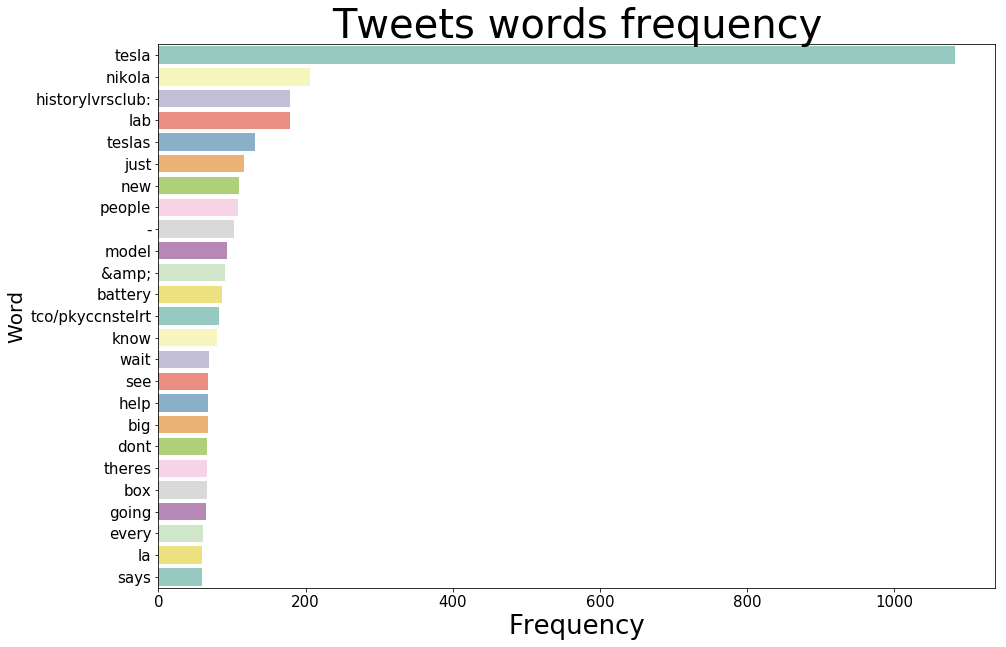

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='Word', x = 'Frequency', data=df2, palette="Set3" )
#sns.despine()
ax.set(xlabel='Tweets words frequency', ylabel='Word')
#ax.set(xticks=range(1, 9), xticklabels=list([10,20,30,40,50,60,70,80,90]))

#ax.set(xticklabels=list(range(0,90,10)))
#plt.figure(figsize=(20,10))

ax.axes.set_title("Tweets words frequency",fontsize=40)
ax.set_xlabel("Frequency",fontsize=26)
ax.set_ylabel("Word",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## achar os países de onde foram gerados os tweets

In [23]:
place = []
for result in results:
    if 'place'in result and result['place']:
        place.append(result['place']['country'])
place = set(place)
print(len(place) )
print(place)

2
{'United States', 'United Kingdom'}


In [25]:
# cidades
place = []
for result in results:
    if 'user'  in result:
        place.append(result['user']['location'])
location = set(place)
len(location)

166

In [26]:
print(location)

{'', 'Cologne, Germany', 'Valencia, España', 'Texcoco', 'London Dungeon Hire', 'LambUniversity', 'Roses, España', 'Gold Coast, Queensland, Aust', 'Madrid, Spain', 'Planet Earth', 'Śląskie, Polska', 'probably by the record player', 'Sabadell, Espanya', 'Vacaville, CA', 'Alicante', 'Delft, Nederland', 'United States *NOTE* Tweets are NOT Investment Advice / Always consult a Licensed Professional for Investments and/or Trading', 'Vancouver, BC (TSX.V: TNR)', 'Gainesville, FL', 'Rio de Janeiro', '1 AU', 'Bronx, NY', 'Chicago, IL', 'Argentina', 'Saint Cloud,FL', 'North Chicago, IL', 'Barcelona, Spain', '赤籠天国', 'Panama', 'Kingdom of Saudi Arabia', 'Pune, India', 'Iceland, Reykjavik ', 'Guernsey', 'Bad Reichenhall', 'Moscow, Moskva, Msc', '24 landen', 'Long Hill New Jersey', 'Mumbai, India', 'Indiana', 'Ohio, USA', 'Santiago, Chile', 'East Africa', 'Nairobi', 'Asturias', 'Vietnam', 'Puebla, México', 'NC. ', 'Memphis', 'İstanbul, Türkiye', 'Perth, Western Australia', 'US', 'SF Bay Area', 'Nair

## contar a ocorrencia de cada cidade

In [27]:
from collections import Counter

c = Counter(location)
#print(c)
cidades = c.items()

## colocando as cidades, frequencia num dataframe e salvando no excel

In [28]:
import pandas as pd
df = pd.DataFrame(([cidade, freq] for cidade, freq in cidades), columns=['city', 'frequency'])

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('cidades.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()
df

,city,frequency
0,,1
1,"Cologne, Germany",1
2,"Valencia, España",1
3,Texcoco,1
4,London Dungeon Hire,1
5,LambUniversity,1
6,"Roses, España",1
7,"Gold Coast, Queensland, Aust",1
8,"Madrid, Spain",1
9,Planet Earth,1


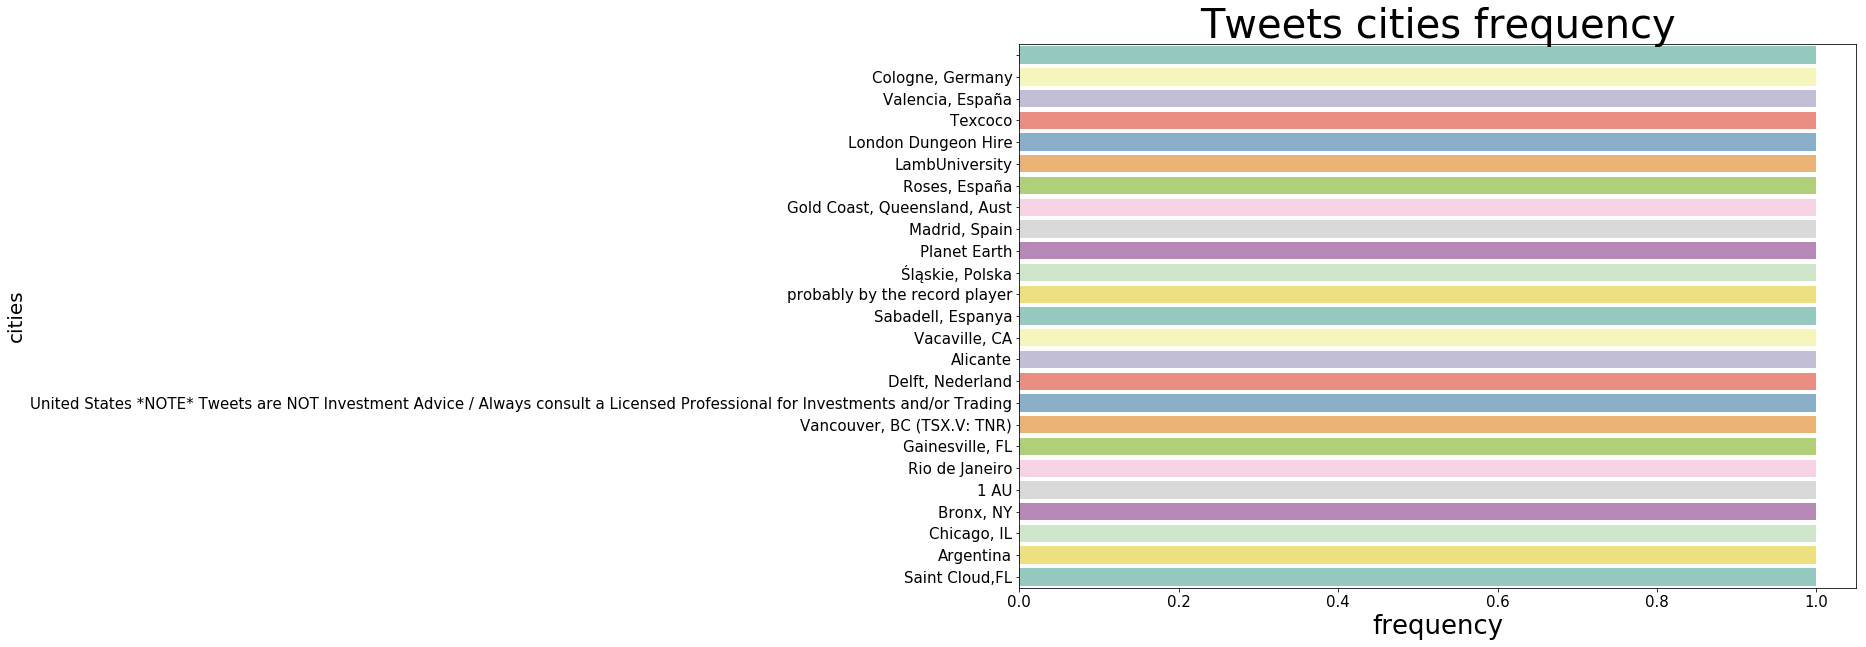

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='city', x = 'frequency', data=df2, palette="Set3" )
ax.set(xlabel='Tweets cities frequency', ylabel='cities')
ax.axes.set_title("Tweets cities frequency",fontsize=40)
ax.set_xlabel("frequency",fontsize=26)
ax.set_ylabel("cities",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## conversao de lat, long para cidade

In [14]:
# !pip install reverse_geocoder
import reverse_geocoder as rg

coordinates = (51.5214588,-0.1729636),(9.936033, 76.259952)
coordinates=(37.38605,-122.08385)
results = rg.search(coordinates) # default mode = 2
print (results)

[OrderedDict([('lat', '37.38605'), ('lon', '-122.08385'), ('name', 'Mountain View'), ('admin1', 'California'), ('admin2', 'Santa Clara County'), ('cc', 'US')])]


In [18]:
import reverse_geocoder as rg

#coordinates = (-23.967967, -47.508358)
#cooordinates = (-8.157554, -35.019805 ), (-8.157554, -34.858893)
cordinates = (-43.4161389,-22.8132778)
cordinates = (-22.8132778, -43.4161389)
results = rg.search(coordinates) # default mode = 2
print (results)

[OrderedDict([('lat', '37.38605'), ('lon', '-122.08385'), ('name', 'Mountain View'), ('admin1', 'California'), ('admin2', 'Santa Clara County'), ('cc', 'US')])]


In [38]:
type(results)

list

In [42]:
results[0]['name']

'Pilar do Sul'

## twitter trends - assuntos mais comentados do momento

In [30]:
import json
import twitter

def twitter_trends(twitter_api, woe_id):
    # Prefix ID with the underscore for query string parameterization.
    # Without the underscore, the twitter package appends the ID value
    # to the URL itself as a special-case keyword argument.
    return twitter_api.trends.place(_id=woe_id)

# Sample usage

twitter_api = oauth_login()

# See https://dev.twitter.com/docs/api/1.1/get/trends/place and
# http://developer.yahoo.com/geo/geoplanet/ for details on
# Yahoo! Where On Earth ID

WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
#print json.dumps(world_trends, indent=1)

US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
#print (json.dumps(us_trends, indent=1))
#us_trends[0]

#for trend in us_trends:
#    print (trend['as_of']['name'])

In [31]:
def find_trends(country_trends):
    trends = country_trends[0]['trends']
    for trend in trends:
        print (trend['name'])

In [32]:
WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
print ("topicos mais comentados: Mundo")
find_trends(world_trends)

topicos mais comentados: Mundo
#FelizJueves
#حمله_وطن_بلا_بدوي
#BlackBuckPoachingCase
#ThursdayThoughts
#من_كثر_ما_البحرين_صغيره
Spyro
Kurt Cobain
Osmangazi Üniversitesi
Iquique
Falciani
アンジュルム
Jean-Vincent Placé
Lamela
Star India
#5Abr
#sunshine
#AvukatlarGünü
#LulaPresoHoje
#مذبحه_الاطفال_في_افغانستان
#BAGANIMayari
#7de7
#طعن_طبيب_في_مستشفي_عرعر
#الخميس_الونيس
#AtTheHashtagConvention
#NRLRaidersBulldogs
#Posiciona2018
#DolarÜçeDüşmeli
#HealTheWorldIn5Words
#PolitikCakImin
#QuintaDetremuraSDV
#NationalBurritoDay
#bürofloskeln
#TeachAFilmToCook
#VachaadayyoSaami
#ケンミンショー
#タイムショック
#İkinci28ŞubatZKPden
#LeyAlquileresJustos
#DíaNacionaldelPeriodista
#GC2018Swimming
#WelcomeToDubaiSuperJunior
#アベンジャーズファンミご招待
#5aprile
#JERZDAY
#سعوديين_ضد_دعم_لبنان
#BitiyorumŞuLafa
#MumbaiWelcomesAmitShah
#Eskisehir
#자캐의_잘생김_혹은_예쁨_설정_여부
#LANYLiveInManila


In [33]:
US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
print ("topicos mais comentados: USA")
find_trends(us_trends)

topicos mais comentados: USA
#ThursdayThoughts
#TheMasters
#HealTheWorldIn5Words
#AtTheHashtagConvention
#NationalBurritoDay
Salman Khan
Mike Rizzo
When Terrorists Run City Hall
Robert Mercer
Delta Air Lines
Rex Tillerson's $12
Maribel Perez Wadsworth
Dr. Evil
Gospel Light Baptist Church
Spyro
Happy Friday Eve
Wanda Greene
Jamie Dimon
Kevin Hogan
Bette Davis
Falciani
Marc Jacobs
World Bank
Crosstown
Guggenheim
Lula da Silva
Johnny Valiant
Lake Shore Drive
National Capital Region
Everybody Knows
#SLCBoston
#TimesItCanGetAwkward
#DeepDishPizzaDay
#JERZDAY
#TeachAFilmToCook
#ITMod18
#GoldStarSpousesDay
#ShellKnew
#Atosdigital
#FenwayPark
#OpeningDaySTL
#KurtCobain
#SaheedVassell
#MorningJoe
#STEMsolve
#healthheroes
#FirstContactDay
#SocialJusticeBandName
#BBFast
#SalesforceTour


In [34]:
BR_WOE_ID = 23424768
br_trends = twitter_trends(twitter_api, BR_WOE_ID)
print ("topicos mais comentados: Brasil")
find_trends(br_trends)

topicos mais comentados: Brasil
#LulaPresoHoje
#QuintaDetremuraSDV
Nem 9h
Com o Supremo
#bomdiafoxquinta
#MaisTwitterEhMenos
Chico Pinheiro
#BDSP
Eduardo Paes
Alerj
Rodoanel
Por 6
Após 1
Barra da Tijuca
Carlinhos Brown
Máfia da Merenda
Foro Privilegiado
Olga Benário
EUA e China
Sepúlveda Pertence
Aecio
Paulinho
Liverpool
Marco Aurélio
Carmen Lúcia
Rodrigo Caio
Cruzeiro
Roma
Exército
Habeas Corpus
Cristiano Ronaldo
Barça
Barcelona
Champions
Lewandowski
Monagas
De Rossi
Villas Boas
Evander
Messi
#SorrindoPraVida
#bdmg
#GabaritandoÉtica
#98Esportes
#LaTorcidaDePapel
#HK7s
#dancingbrasil
#SandyNoTVZ
#PremiosMTVMiaw
#Inter109Anos
